In [1]:
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

def load_ground_truth(gt_file_path):
    """Load and preprocess the ground truth data."""
    gt = pd.read_csv(gt_file_path, header=None)
    gt.columns = ["table_name", "row", "col", "qid"]
    url_regex = re.compile(r"http(s)?\:////www/.wikidata/.org\/(wiki|entity)\/")
    gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
    return gt

def create_gt_mapping(gt, include_nil):
    """Create mappings for ground truth based on whether to include NIL values."""
    if include_nil:
        return {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}, {}
    else:
        gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples() if row.qid.startswith("Q")}
        gt_mapping_nil = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples() if row.qid.lower() == "nil"}
        return gt_mapping, gt_mapping_nil

def calculate_metrics(alligator_annotations, gt_mapping, gt_mapping_nil, include_nil, current_table_name, threshold=0.0):
    """Calculate precision, recall, and F1 scores for a specific threshold."""
    fn, fp, tn, tp = 0, 0, 0, 0

    for annotation in alligator_annotations:
        key = f"{current_table_name}-{annotation['idRow']}-{annotation['idColumn']}"

        # Skip if the target is NIL if we are not including NIL values
        if not include_nil and key not in gt_mapping:
            continue

        # Is it a NIL prediction?
        if len(annotation["entity"]) == 0 or annotation["entity"][0]["score"] < threshold:
            predicted_qid = "NIL"
        else:
            predicted_qid = annotation["entity"][0]["id"]

        target = gt_mapping.get(key, {}).get("target", [])

        if predicted_qid == "NIL" and target == "NIL":
            tn += 1
        elif predicted_qid == "NIL" and target != "NIL":
            fn += 1
        elif predicted_qid != "NIL" and (target == "NIL" or predicted_qid != target):
            fp += 1
        elif predicted_qid != "NIL" and target != "NIL" and predicted_qid == target:
            tp += 1
        else:
            raise ValueError("case leftout")

    precision = (tp / (tp + fp)) if tp + fp > 0 else 0
    recall = (tp / (tp + fn)) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

def plot_metrics(performance_metrics_df, include_nil):
    """Plot precision, recall, and F1 scores against thresholds."""
    plt.figure(figsize=(10, 6))
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["precision"], label='Precision')
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["recall"], label='Recall')
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["f1"], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Performance Metrics vs. Threshold ({"Including" if include_nil else "Excluding"} NIL)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_score_distribution(scores, title):
    """Plot a histogram for score distribution."""
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def extract_scores(alligator_annotations, gt_mapping, current_table_name, include_nil=False):
    """Extract scores for NIL or non-NIL entities."""
    scores = []
    for mention in alligator_annotations:
        key = f"{current_table_name}-{mention['idRow']}-{mention['idColumn']}"
        if include_nil and key in gt_mapping:
            scores.append(mention["entity"][0]["score"] if mention["entity"] else 0)
        elif not include_nil and key in gt_mapping:
            scores.append(mention["entity"][0]["score"] if mention["entity"] else 0)
    return scores

if __name__ == "__main__":
    alligator_annotations_path = "../Results/alligator_annotations_github-testset_babakAlessandro_02_Github_Testset.json"
    gt_file_path = '../Data/AlessandroBabak_Annotations_Github_Testset/gt/cea_gt.csv'
    current_table_name = 'Github_Testset'

    gt = load_ground_truth(gt_file_path)

    with open(alligator_annotations_path) as f:
        alligator_annotations = json.load(f)["semanticAnnotations"]["cea"]

    for include_nil in [False, True]:
        print(f"{'\nIncluding' if include_nil else 'Excluding'} NIL values")
        gt_mapping, gt_mapping_nil = create_gt_mapping(gt, include_nil)
        performance_metrics = []

        threshold = 0
        precision, recall, f1 = calculate_metrics(alligator_annotations, gt_mapping, gt_mapping_nil, include_nil, current_table_name, threshold)
        performance_metrics.append([threshold, precision, recall, f1])

        performance_metrics_df = pd.DataFrame(performance_metrics, columns=["threshold", "precision", "recall", "f1"])
        print(performance_metrics_df.to_markdown())



Excluding NIL values
|    |   threshold |   precision |   recall |       f1 |
|---:|------------:|------------:|---------:|---------:|
|  0 |           0 |    0.614191 | 0.989286 | 0.757866 |

Including NIL values
|    |   threshold |   precision |   recall |       f1 |
|---:|------------:|------------:|---------:|---------:|
|  0 |           0 |    0.375848 | 0.989286 | 0.544739 |


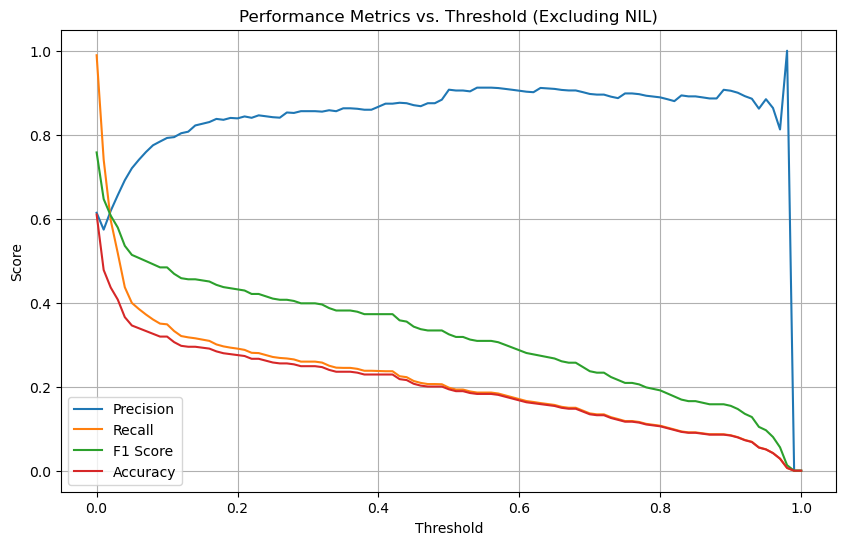

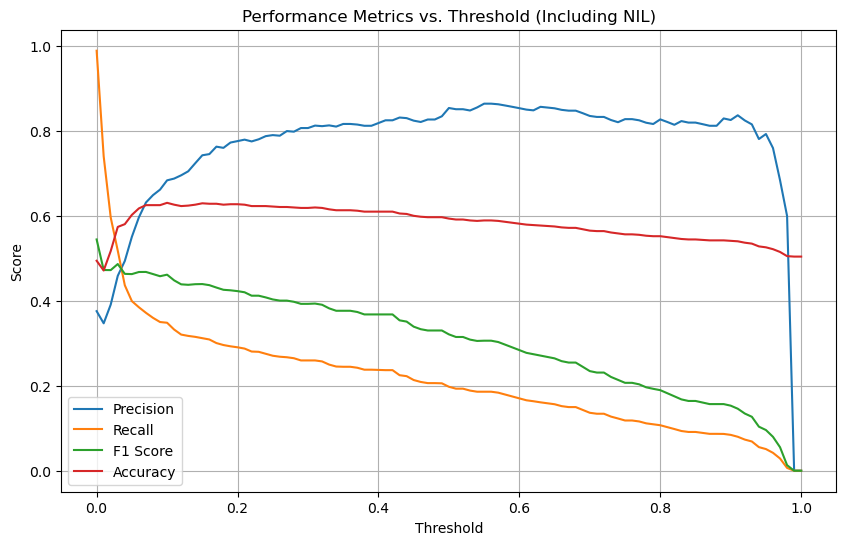

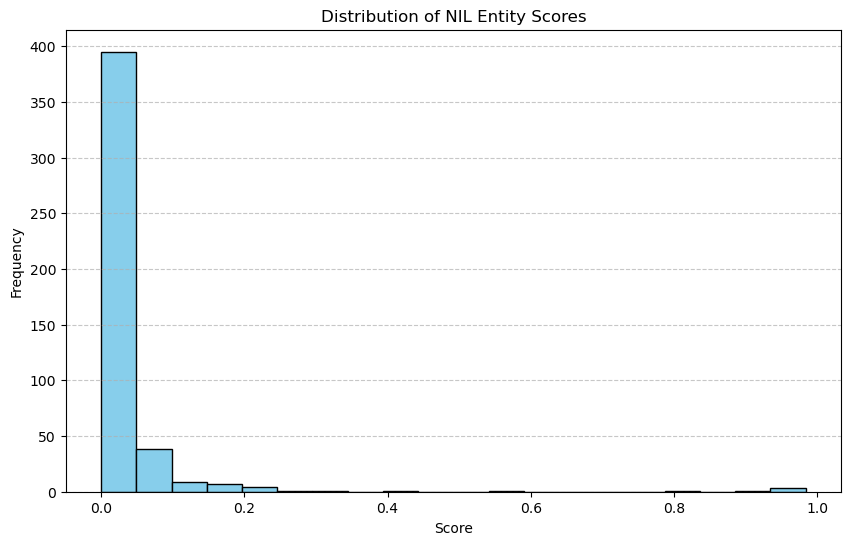

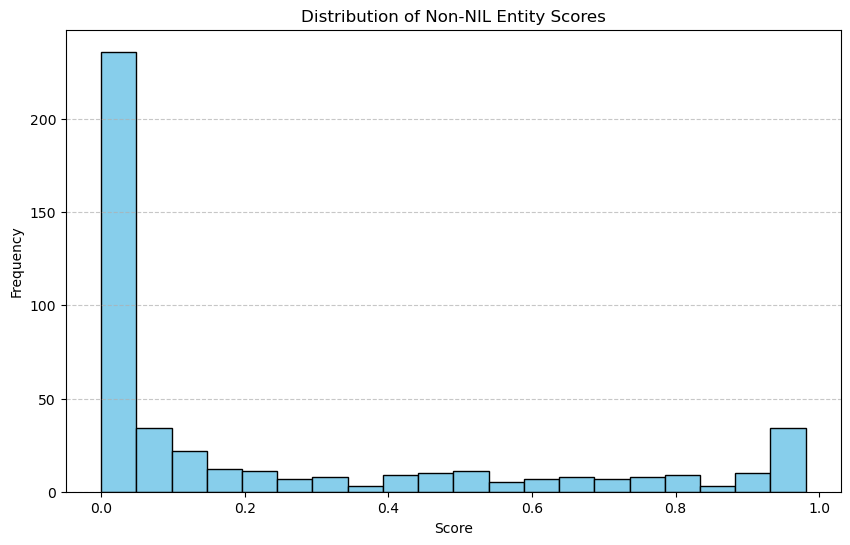

In [2]:
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

def load_ground_truth(gt_file_path):
    """Load and preprocess the ground truth data."""
    gt = pd.read_csv(gt_file_path, header=None)
    gt.columns = ["table_name", "row", "col", "qid"]
    url_regex = re.compile(r"http(s)?\:////www/.wikidata/.org\/(wiki|entity)\/")
    gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
    return gt

def create_gt_mapping(gt, include_nil):
    """Create mappings for ground truth based on whether to include NIL values."""
    if include_nil:
        return {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}, {}
    else:
        gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples() if row.qid.startswith("Q")}
        gt_mapping_nil = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples() if row.qid.lower() == "nil"}
        return gt_mapping, gt_mapping_nil

def calculate_metrics(alligator_annotations, gt_mapping, gt_mapping_nil, include_nil, current_table_name, threshold=0.0):
    """Calculate precision, recall, F1 scores, and accuracy for a specific threshold."""
    fn, fp, tn, tp = 0, 0, 0, 0

    for annotation in alligator_annotations:
        key = f"{current_table_name}-{annotation['idRow']}-{annotation['idColumn']}"

        # Skip if the target is NIL if we are not including NIL values
        if not include_nil and key not in gt_mapping:
            continue

        # Is it a NIL prediction?
        if len(annotation["entity"]) == 0 or annotation["entity"][0]["score"] < threshold:
            predicted_qid = "NIL"
        else:
            predicted_qid = annotation["entity"][0]["id"]

        target = gt_mapping.get(key, {}).get("target", [])

        if predicted_qid == "NIL" and target == "NIL":
            tn += 1
        elif predicted_qid == "NIL" and target != "NIL":
            fn += 1
        elif predicted_qid != "NIL" and (target == "NIL" or predicted_qid != target):
            fp += 1
        elif predicted_qid != "NIL" and target != "NIL" and predicted_qid == target:
            tp += 1
        else:
            raise ValueError("case leftout")

    precision = (tp / (tp + fp)) if tp + fp > 0 else 0
    recall = (tp / (tp + fn)) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = ((tp + tn) / (tp + tn + fp + fn)) if (tp + tn + fp + fn) > 0 else 0

    return precision, recall, f1, accuracy

def plot_metrics(performance_metrics_df, include_nil):
    """Plot precision, recall, F1 scores, and accuracy against thresholds."""
    plt.figure(figsize=(10, 6))
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["precision"], label='Precision')
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["recall"], label='Recall')
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["f1"], label='F1 Score')
    plt.plot(performance_metrics_df["threshold"], performance_metrics_df["accuracy"], label='Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Performance Metrics vs. Threshold ({"Including" if include_nil else "Excluding"} NIL)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_score_distribution(scores, title):
    """Plot a histogram for score distribution."""
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def extract_scores(alligator_annotations, gt_mapping, current_table_name, include_nil=False):
    """Extract scores for NIL or non-NIL entities."""
    scores = []
    for mention in alligator_annotations:
        key = f"{current_table_name}-{mention['idRow']}-{mention['idColumn']}"
        if include_nil and key in gt_mapping:
            scores.append(mention["entity"][0]["score"] if mention["entity"] else 0)
        elif not include_nil and key in gt_mapping:
            scores.append(mention["entity"][0]["score"] if mention["entity"] else 0)
    return scores

if __name__ == "__main__":
    alligator_annotations_path = "../Results/alligator_annotations_github-testset_babakAlessandro_02_Github_Testset.json"
    gt_file_path = '../Data/AlessandroBabak_Annotations_Github_Testset/gt/cea_gt.csv'
    current_table_name = 'Github_Testset'

    gt = load_ground_truth(gt_file_path)

    with open(alligator_annotations_path) as f:
        alligator_annotations = json.load(f)["semanticAnnotations"]["cea"]

    for include_nil in [False, True]:
        gt_mapping, gt_mapping_nil = create_gt_mapping(gt, include_nil)
        performance_metrics = []

        for threshold in np.arange(0.0, 1.001, 0.01):
            precision, recall, f1, accuracy = calculate_metrics(alligator_annotations, gt_mapping, gt_mapping_nil, include_nil, current_table_name, threshold)
            performance_metrics.append([threshold, precision, recall, f1, accuracy])

        performance_metrics_df = pd.DataFrame(performance_metrics, columns=["threshold", "precision", "recall", "f1", "accuracy"])
        plot_metrics(performance_metrics_df, include_nil)

    # Plot score distributions for non-NIL and NIL entities
    gt_mapping, gt_mapping_nil = create_gt_mapping(gt, include_nil=False)
    nil_scores = extract_scores(alligator_annotations, gt_mapping_nil, current_table_name, include_nil=True)
    non_nil_scores = extract_scores(alligator_annotations, gt_mapping, current_table_name, include_nil=False)
    plot_score_distribution(nil_scores, 'Distribution of NIL Entity Scores')
    plot_score_distribution(non_nil_scores, 'Distribution of Non-NIL Entity Scores')


In [3]:
def extract_candidates_with_zero_score(alligator_annotations, current_table_name):
    """Extract samples of candidates with a score of 0."""
    zero_score_candidates = []

    for mention in alligator_annotations:
        key = f"{current_table_name}-{mention['idRow']}-{mention['idColumn']}"
        if mention["entity"] and mention["entity"][0]["score"] == 0:
            zero_score_candidates.append({
                "key": key,
                "entity_id": mention["entity"][0]["id"],
                "entity_label": mention["entity"][0].get("label", ""),
                "score": mention["entity"][0]["score"]
            })

    return zero_score_candidates

# Example usage
zero_score_samples = extract_candidates_with_zero_score(alligator_annotations, current_table_name)

# Display a sample of the zero score candidates
for sample in zero_score_samples[:10]:  # Adjust the slice to see more/less samples
    print(sample)


{'key': 'Github_Testset-249-0', 'entity_id': 'Q125489538', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-377-0', 'entity_id': 'Q125489389', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-585-0', 'entity_id': 'Q17518896', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-598-0', 'entity_id': 'Q1851075', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-470-0', 'entity_id': 'Q10315155', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-530-0', 'entity_id': 'Q1367256', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-535-0', 'entity_id': 'Q96707477', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-509-0', 'entity_id': 'Q12070837', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-814-0', 'entity_id': 'Q56815975', 'entity_label': '', 'score': 0.0}
{'key': 'Github_Testset-822-0', 'entity_id': 'Q6040337', 'entity_label': '', 'score': 0.0}


In [4]:
def extract_candidates_with_zero_score_and_rows(alligator_annotations, current_table_name, annotations_rows):
    """
    Extract samples of candidates with a score of 0 and their corresponding rows.
    
    Parameters:
    - alligator_annotations: List of annotation data.
    - current_table_name: The name of the current table.
    - annotations_rows: The rows data from the annotations file.

    Returns:
    - List of dictionaries containing zero-score candidates and their rows.
    """
    zero_score_candidates_with_rows = []

    for mention in alligator_annotations:
        key = f"{current_table_name}-{mention['idRow']}-{mention['idColumn']}"
        if mention["entity"] and mention["entity"][0]["score"] == 0:
            # Find the corresponding row from annotations_rows
            corresponding_row = next(
                (row for row in annotations_rows if row.get("idRow") == mention["idRow"]),
                None
            )

            zero_score_candidates_with_rows.append({
                "key": key,
                "entity_id": mention["entity"][0]["id"],
                "entity_label": mention["entity"][0].get("label", ""),
                "score": mention["entity"][0]["score"],
                "row": corresponding_row
            })

    return zero_score_candidates_with_rows

# Example usage
with open(alligator_annotations_path) as f:
    annotations_data = json.load(f)

annotations_rows = annotations_data.get("rows", [])
zero_score_samples_with_rows = extract_candidates_with_zero_score_and_rows(
    alligator_annotations, current_table_name, annotations_rows
)

# Display a sample of the results
for sample in zero_score_samples_with_rows[:10]:  # Adjust the slice to see more/less samples
    print(sample)


{'key': 'Github_Testset-249-0', 'entity_id': 'Q125489538', 'entity_label': '', 'score': 0.0, 'row': {'idRow': 249, 'data': ['BRAVEHAT'], 'ids': ['NIL']}}
{'key': 'Github_Testset-377-0', 'entity_id': 'Q125489389', 'entity_label': '', 'score': 0.0, 'row': {'idRow': 377, 'data': ['FarMart'], 'ids': ['NIL']}}
{'key': 'Github_Testset-585-0', 'entity_id': 'Q17518896', 'entity_label': '', 'score': 0.0, 'row': {'idRow': 585, 'data': ['Folkhalsomyndigheten'], 'ids': ['Q17518896']}}
{'key': 'Github_Testset-598-0', 'entity_id': 'Q1851075', 'entity_label': '', 'score': 0.0, 'row': {'idRow': 598, 'data': ['@laboratoriobridge '], 'ids': ['Q1851075']}}
{'key': 'Github_Testset-470-0', 'entity_id': 'Q10315155', 'entity_label': '', 'score': 0.0, 'row': {'idRow': 470, 'data': ['@ExceedLabs'], 'ids': ['Q10315155']}}
{'key': 'Github_Testset-530-0', 'entity_id': 'Q1367256', 'entity_label': '', 'score': 0.0, 'row': {'idRow': 530, 'data': ['HackBio'], 'ids': ['Q1367256']}}
{'key': 'Github_Testset-535-0', 'ent